<font size="6">
<p align="center"><b>XGLMBoost</b> <br>
Ein Versuch der Kombination von GLM und XGBoost</p>

# Abbildungsverzeichnis <a class="anchor" id="abbildungsverzeichnis"></a>

# Dependencies <a class="anchor" id="dependencies"></a>

<font size="3">
Zur Ausführung des Codes in diesem Notebook sind die folgenden Bibliotheken notwendig:

In [2]:
import numpy as np
import pandas as pd
import math
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.gridspec import GridSpec
from sklearn.linear_model import LinearRegression,PoissonRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.gridspec import GridSpec
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

2023-08-31 19:02:51.200385: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<hr>

# 1. Einleitung <a class="anchor" id="1-bullet"></a>

<hr>

<font size="3">
<em>XGLMBoost</em>  ist eine neuartige Erweiterung für generalisierte lineare Modelle (GLM), die auf dem Konzept des Boosting basiert und vom XGBoost-Ansatz inspiriert ist. Diese Erweiterung zielt darauf ab, die Erklärbarkeit von GLMs durch die Kombination von Residuenanalyse und Boosting zu verbessern. Der Aufbau basiert auf dem Projekt pyLocalGLMnet, das eine Python-Implementierung des Richman/Wüthrich-Ansatzes enthält. 
Die Grundidee von XGLMBoost besteht darin, die Vorhersagegenauigkeit eines klassischen GLM durch die Integration von Boosting zu erhöhen und gleichzeitig die Interpretierbarkeit der Modellvorhersagen zu verbessern. Dabei werden die Residuen, d.h. die Differenz zwischen den beobachteten und den vorhergesagten Werten des GLM, als neues Trainingsziel für das Boosting verwendet. Dieser Ansatz ermöglicht es, die Modellfehler gezielt zu reduzieren und gleichzeitig die Interpretierbarkeit der Modellvorhersagen zu erhalten.<br>
<br>
Der erste Datensatz ist ähnlich wie beim ursprünglichen XGBoost-Ansatz ein synthetischer Datensatz. Dieser dient dazu, die Wirksamkeit und die Grenzen unseres XGLMBoost-Ansatzes zu veranschaulichen, da der wahre Zusammenhang bekannt ist. Anschließend demonstrieren wir die Anwendung von XGLMBoost auf reale Daten: Wir betrachten die Vorhersage von Schadensfällen in der Kfz-Haftpflichtversicherung. Diese praktische Anwendung zeigt die Nützlichkeit und Anpassbarkeit unseres Ansatzes an reale Probleme.


<hr>

# 2. Datensatz 1: Künstlicher Datensatz <a class="anchor" id="2-bullet"></a>

<hr>

## 2.1 Künstlichen Datensatz erzeugen <a class="anchor" id="2_1-bullet"></a>

<font size="3">
Der synthetische Datensatz besteht aus insgesamt 8 Merkmalen. <em>x7</em> und <em>x8</em> haben keinen Einfluss auf die Zielvariable. <em>x8</em> ist jedoch zu 50% mit <em>x2</em> korreliert. Der funktionale Zusammenhang der Zielvariable ergibt sich wie folgt:

\begin{equation} 
\mu\left( x \right)=\frac{1}{2}x_{1}-\frac{1}{4}x^2_{2}+\frac{1}{2}\left\lvert x_{3} \right\rvert sin\left( 2x_{3} \right)+\frac{1}{2}x_{4}x_{5}+\frac{1}{8}x^{2}_{5}x_{6}
\end{equation}

Die Merkmalsausprägungen werden mithilfe des Zufallsgenerators von Numpy auf Basis einer Standardnormalverteilung erzeugt. Hierdurch sind die Merkmale bereits standardisiert, d. h. alle haben den Mittelwert <em>µ=0</em> und <em>std=1</em>. Bei einem anderen Datensatz müssten die Merkmale zuerst standardisiert werden, damit die Werte die gleiche Größenordnung haben. Da die Daten künstlich erzeugt werden, wird sowohl ein Trainings- als auch ein Testdatensatz mit 100000 Beobachtungen erzeugt. Bei einem realen Datensatz müsste der vorhandene Datensatz entsprechend aufgeteilt werden (bspw. 80:20).

In [29]:
# Zielfunktion
def target_variable(x):
    return (
        (1 / 2) * x[0]
        - (1 / 4) * (x[1] ** 2)
        + (1 / 2) * abs(x[2]) * math.sin(2 * x[2])
        + (1 / 2) * x[3] * x[4]
        + (1 / 8) * (x[4] ** 2) * x[5]
    )

In [30]:
# Random Number Generator
rng = np.random.default_rng()

In [31]:
# Trainingsdatensatz (n = 100.000) erzeugen (Variablen x1, x3, x4, x5, x6, x7)
x1_train = rng.standard_normal(size=(100000, 1))
x3_7_train = rng.standard_normal(size=(100000, 5))

# Variablen x2, x8 mit 50 % Korrelation erzeugen
cov_matrix = [[1, 0.5], [0.5, 1]]
x2_x8_train = rng.multivariate_normal(mean=[0, 0], cov=cov_matrix, size=100000)

# Trainingsdatensatz zusammenfügen und Zielvariable y bestimmen
x_train = np.column_stack((x1_train, x2_x8_train[:, 0], x3_7_train, x2_x8_train[:, 1]))
y_train = np.array(list(map(target_variable, x_train[:, 0:7])))

In [32]:
# Testdatensatz (n = 100.000) erzeugen (Variablen x1, x3, x4, x5, x6, x7)
x1_test = rng.standard_normal(size=(100000, 1))
x3_7_test = rng.standard_normal(size=(100000, 5))

# Variablen x2, x8 mit 50 % Korrelation erzeugen
x2_x8_test = rng.multivariate_normal(mean=[0, 0], cov=cov_matrix, size=100000)

# Testdatensatz zusammenfügen und Zielvariable y bestimmen
x_test = np.column_stack((x1_test, x2_x8_test[:, 0], x3_7_test, x2_x8_test[:, 1]))
y_test = np.array(list(map(target_variable, x_test[:, 0:7])))

## 2.2 XGLMBoost <a class="anchor" id="2_2-bullet"></a>

<font size="3">
In diesem Kapitel soll auf Basis der Trainingsdaten zuerst ein klassisches GLM trainert und danach geboostet. Für diese bietet sich daraufhin der Vergleich der Vorhersagegenauigkeit beider Modelle an.

### 2.2.1 GLM <a class="anchor" id="2_2_1-bullet"></a>

<font size="3">
Generalisierte lineare Modelle, abgekürzt GLM, erweitern herkömmliche lineare Regressionsmodelle zur Abbildung nichtlinearer Zusammenhänge [2]. Im Wesentlichen bestehen GLMs aus drei Hauptkomponenten: der systematischen Komponente, der Verbindungsfunktion und der Zufallskomponente. Die systematische Komponente entspricht den klassischen Regressionsparametern einer linearen Funktion. Die Zufallskomponente beschreibt die Verteilung der Residuen eines herkömmlichen linearen Regressionsmodells. Im Gegensatz zur Forderung nach einer Normalverteilung bei der klassischen linearen Regression erlaubt ein GLM die Verwendung anderer Verteilungen aus der Exponentialfamilie, wie z. B. die Binomial- oder Poisson-Verteilung. Die Verknüpfungsfunktion verknüpft die Regressionsparameter mit der angegebenen Zufallskomponente. Die Wahl der Zufallskomponente und der entsprechenden Verknüpfungsfunktion hängt von der spezifischen Problemstellung und den vorliegenden Daten ab. Weitere Informationen zur Wahl der Verknüpfungsfunktion finden sich z. B. in [2]. GLMs finden in verschiedenen Anwendungsbereichen, wie z.B. im Versicherungswesen, vielfältige Einsatzmöglichkeiten, da ihre Ergebnisse auf Basis der Koeffizienten gut interpretierbar sind.
<br><br>
Für den synthetischen Datensatz wurde im pyLoccalGLMnet die Identity-Link Funktion verwendet. Das resultierende GLM entspricht also einer klassischen linearen Regression. Um ein GLM mit Python zu erzeugen, bieten sich Bibliotheken wie scikit-learn an.

In [33]:
glm = LinearRegression()
glm.fit(x_train, y_train)

y_pred_glm = glm.predict(x_test)

### 2.2.2 XGLMBoost <a class="anchor" id="2_2_2-bullet"></a>

<font size="3">
In diesem Teil des Codes wird der Begriff "Residuen" verwendet, um die Differenz zwischen den tatsächlichen Testzielwerten (y_test) und den Vorhersagen des linearen Regressionsmodells (y_pred_glm) zu beschreiben. Residuen sind die Abweichungen oder Fehler zwischen den tatsächlichen Beobachtungswerten und den vom Modell vorhergesagten Werten.
<br><br>
Die Zeile residuals = y_test - y_pred_glm berechnet diese Residuen. Durch Subtraktion der Vorhersagen des linearen Regressionsmodells von den tatsächlichen Testzielwerten werden die Abweichungen zwischen den vorhergesagten und den tatsächlichen Werten ermittelt. Sind die Residuen positiv, so hat das Modell die Werte unterschätzt, sind sie negativ, so hat das Modell die Werte überschätzt.

In [34]:
# Residuen berechnen
residuals = y_test - y_pred_glm

<font size="3">
Es werden Arrays initialisiert, um die Vorhersagen der drei Boosting-Modelle (Decision Trees, Random Forest und Gradient Boosting) zu speichern. Diese Arrays werden in den folgenden Iterationen verwendet, um die kumulativen Auswirkungen der Boosting-Schritte zu verfolgen und die Gesamtvorhersagen für jedes Modell zu erstellen.
<br><br>
boosted_predictions_dt, boosted_predictions_rf und boosted_predictions_gb: Diese Arrays werden mit Nullen initialisiert und haben die gleiche Form wie das Array y_pred_glm, das die Vorhersagen des linearen Regressionsmodells enthält. Diese Arrays werden später in den Boosting-Schleifen verwendet, um die schrittweisen Verbesserungen der Vorhersagen durch die Boosting-Modelle zu speichern.
<br><br>
n_iterations: Dies ist eine vordefinierte Anzahl von Iterationen, die in den Boosting-Schleifen durchlaufen werden. Jede Iteration fügt dem Modell eine weitere Komponente hinzu, um die Vorhersagegenauigkeit schrittweise zu verbessern.
<br><br>
learning_rate: Die Lernrate ist ein Parameter, der angibt, wie stark die Vorhersagen der Boosting-Modelle in jeder Iteration berücksichtigt werden. Eine höhere Lernrate bedeutet eine stärkere Berücksichtigung der Boosting-Vorhersagen, aber auch ein höheres Risiko des Overfittings.

In [35]:
# Initialisiere Arrays für die Vorhersagen
boosted_predictions_dt = np.zeros_like(y_pred_glm)
boosted_predictions_rf = np.zeros_like(y_pred_glm)
boosted_predictions_gb = np.zeros_like(y_pred_glm)

n_iterations = 10
learning_rate = 0.5

<font size="3">
In diesem Abschnitt wird eine Boosting-Iteration für Entscheidungsbaum-, Random Forest und Gradient Boosting-Verfahren durchgeführt, um die Vorhersagegenauigkeit zu verbessern. Innerhalb einer Schleife werden mehrere Iterationen durchgeführt. In jeder Iteration wird ein spezifisches Boosting-Modell erstellt und auf die verbleibenden Fehler des ursprünglichen Modells trainiert. Die Vorhersagen dieses Boosting-Modells werden mit einer Lernrate skaliert und zu den vorherigen Boosting-Vorhersagen addiert. Die Residuen, die die Differenz zwischen den tatsächlichen Werten und den bisherigen Vorhersagen darstellen, werden aktualisiert. Am Ende der Schleife werden die kumulierten Vorhersagen des spezifischen Boosting-Modells zu den ursprünglichen glm-Vorhersagen addiert, um die Gesamtvorhersagen zu erzeugen. Dieser Prozess wird in mehreren Iterationen wiederholt, um die Gesamtprognosen schrittweise zu verbessern.

In [36]:
# Boosting-Schleife Decission Tree
for i in range(n_iterations):
 
    boosting_model_dt = DecisionTreeRegressor(max_depth=50)
    boosting_model_dt.fit(x_train, residuals)
    boosted_residuals_dt = boosting_model_dt.predict(x_train)
    boosted_predictions_dt += learning_rate * boosted_residuals_dt

    # Aktualisierung der Residuen
    residuals = y_test - y_pred_glm - boosted_predictions_dt 

# Vorhersage Decission Tree
y_pred_boosted_dt = y_pred_glm + boosted_predictions_dt

In [37]:
# Boosting-Schleife Random Forest
for i in range(n_iterations):
 
    boosting_model_rf = RandomForestRegressor(max_depth=50)
    boosting_model_rf.fit(x_train, residuals)
    boosted_residuals_rf = boosting_model_rf.predict(x_train)
    boosted_predictions_rf += learning_rate * boosted_residuals_rf

    # Aktualisierung der Residuen
    residuals = y_test - y_pred_glm - boosted_predictions_rf 

# Vorhersage Random Forest
y_pred_boosted_rf = y_pred_glm + boosted_predictions_rf

In [38]:
# Boosting-Schleife Gradient Boosting
for i in range(n_iterations):
 
    boosting_model_gb = GradientBoostingRegressor(max_depth=50)
    boosting_model_gb.fit(x_train, residuals)
    boosted_residuals_gb = boosting_model_gb.predict(x_train)
    boosted_predictions_gb += learning_rate * boosted_residuals_gb

    # Aktualisierung der Residuen
    residuals = y_test - y_pred_glm - boosted_predictions_gb 

# Vorhersage Gradient Boosting
y_pred_boosted_gb = y_pred_glm + boosted_predictions_gb

### 2.2.3 Performance Vergleich <a class="anchor" id="2_2_3-bullet"></a>

<font size="3">
In diesem Abschnitt werden verschiedene Evaluierungsmetriken berechnet, um die Leistung der Boosting-Modelle (Decision Trees, Random Forest und Gradient Boosting) sowie des ursprünglichen linearen Regressionsmodells (GLM) zu bewerten. Die berechneten Metriken bieten Einblicke in die Genauigkeit und Effektivität der verschiedenen Modelle bei der Vorhersage.
<br><br>

### Berechnung des Mean Squared Error (MSE)
Der Mean Squared Error misst die durchschnittliche quadratische Abweichung zwischen den tatsächlichen Werten und den vorhergesagten Werten. Für jedes Modell (Decision Tree, Random Forest, Gradient Boosting und GLM) wird der MSE berechnet und gespeichert.
<br><br>

### Berechnung von R^2
Der R^2-Wert, auch als Bestimmtheitsmaß bekannt, gibt an, wie gut die Vorhersagen im Vergleich zu einem einfachen Durchschnittsmodell sind. Er reicht von 0 (schlechte Anpassung) bis 1 (perfekte Anpassung). Die R^2-Werte werden für jedes Modell berechnet und gespeichert.
<br><br>

### Berechnung des Mean Absolute Error (MAE)
Der Mean Absolute Error misst die durchschnittliche absolute Abweichung zwischen den tatsächlichen Werten und den vorhergesagten Werten. Er liefert eine Vorstellung von der durchschnittlichen Größe der Fehler. MAE-Werte werden für jedes Modell berechnet und gespeichert.
<br><br>

### Berechnung des Root Mean Squared Error (RMSE)
Der Root Mean Squared Error ist die Quadratwurzel des MSE und gibt die durchschnittliche Abweichung zwischen den tatsächlichen und vorhergesagten Werten in den ursprünglichen Einheiten der Zielvariable wieder. RMSE-Werte werden für jedes Modell berechnet und gespeichert.

Anschließend werden die berechneten Metriken in einem übersichtlichen Dataframe zusammengefasst und ausgegeben. Dieser Dataframe zeigt die Performance jedes Modells in Bezug auf die verschiedenen Metriken, was einen direkten Vergleich ermöglicht und dabei hilft, das am besten geeignete Modell für die spezifische Anwendung zu identifizieren.

In [39]:
# Berechnung des Mean Squared Error (MSE)
mse_dt = mean_squared_error(y_test, y_pred_boosted_dt)
mse_rf = mean_squared_error(y_test, y_pred_boosted_rf)
mse_gb = mean_squared_error(y_test, y_pred_boosted_gb)
mse_glm = mean_squared_error(y_test, y_pred_glm)

# Berechnung von R^2
r2_dt = r2_score(y_test, y_pred_boosted_dt)
r2_rf = r2_score(y_test, y_pred_boosted_rf)
r2_gb = r2_score(y_test, y_pred_boosted_gb)
r2_glm = r2_score(y_test, y_pred_glm)

# Berechnung des Mean Absolute Error (MAE)
mae_dt = mean_absolute_error(y_test, y_pred_boosted_dt)
mae_rf = mean_absolute_error(y_test, y_pred_boosted_rf)
mae_gb = mean_absolute_error(y_test, y_pred_boosted_gb)
mae_glm = mean_absolute_error(y_test, y_pred_glm)

# Berechnung des Root Mean Squared Error (RMSE)
rmse_dt = mean_squared_error(y_test, y_pred_boosted_dt, squared=False)
rmse_rf = mean_squared_error(y_test, y_pred_boosted_rf, squared=False)
rmse_gb = mean_squared_error(y_test, y_pred_boosted_gb, squared=False)
rmse_glm = mean_squared_error(y_test, y_pred_glm, squared=False)


models = ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'GLM']

# Berechnung der Metriken für die Modelle
mse_scores = [mse_dt, mse_rf, mse_gb, mse_glm]
r2_scores = [r2_dt, r2_rf, r2_gb, r2_glm]
mae_scores = [mae_dt, mae_rf, mae_gb, mae_glm]
rmse_scores = [rmse_dt, rmse_rf, rmse_gb, rmse_glm]

# Erstellen eines DataFrames für die Ausgabe
data = {'Model': models, 'MSE': mse_scores, 'R^2': r2_scores, 'MAE': mae_scores, 'RMSE': rmse_scores}
metrics_df = pd.DataFrame(data)

# Ausgabe der Metriken-Tabelle
print(metrics_df)

               Model       MSE       R^2       MAE      RMSE
0      Decision Tree  0.000085  0.999893  0.005447  0.009203
1      Random Forest  0.001910  0.997591  0.032722  0.043708
2  Gradient Boosting  0.000002  0.999998  0.001014  0.001388
3                GLM  0.528027  0.334215  0.531085  0.726654


<font size="3">
Die Vorhersagen der Modelle werden visuell verglichen und dargestellt. Es wird eine Visualisierung erstellt, die die Beziehung zwischen den wahren (tatsächlichen) Werten und den geschätzten Werten für jedes Modell zeigt.

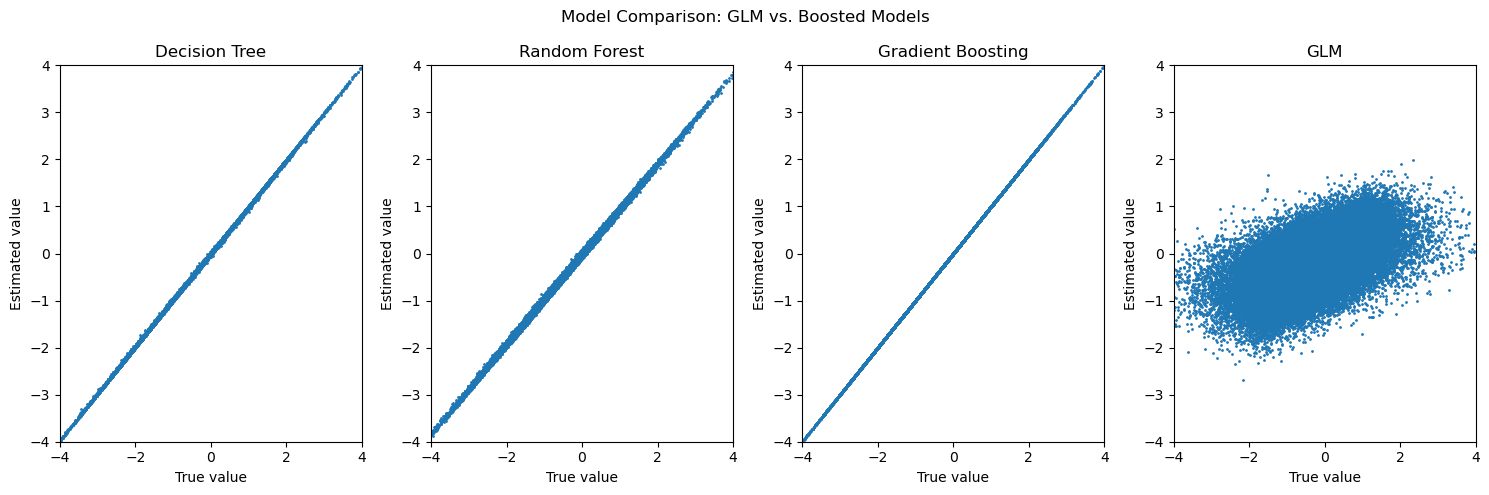

In [40]:
# Visualisierung der Vorhersagen
fig_performance = plt.figure(tight_layout=True, figsize=(15, 5))
spec = GridSpec(ncols=4, nrows=1, figure=fig_performance)
axs_perf = [
    fig_performance.add_subplot(spec[0, 0]),
    fig_performance.add_subplot(spec[0, 1]),
    fig_performance.add_subplot(spec[0, 2]),
    fig_performance.add_subplot(spec[0, 3]),
]

# Scatterplots für die vier Modelle
axs_perf[0].scatter(y_test, y_pred_boosted_dt, s=1)
axs_perf[0].set_title("Decision Tree")

axs_perf[1].scatter(y_test, y_pred_boosted_rf, s=1)
axs_perf[1].set_title("Random Forest")

axs_perf[2].scatter(y_test, y_pred_boosted_gb, s=1)
axs_perf[2].set_title("Gradient Boosting")

axs_perf[3].scatter(y_test,  y_pred_glm, s=1)
axs_perf[3].set_title("GLM")

# Gemeinsame Layout-Einstellungen
for ax in axs_perf:
    ax.set_xlabel("True value")
    ax.set_ylabel("Estimated value")
    ax.set_xlim((-4, 4))
    ax.set_ylim((-4, 4))

fig_performance.suptitle("Model Comparison: GLM vs. Boosted Models")
plt.show()

<font size="3">
Die Ergebnisse der Modellbewertung zeigen signifikante Unterschiede in der Vorhersageleistung der verschiedenen Modelle. Die Metriken bieten Einblick in verschiedene Aspekte der Modellgenauigkeit.
<br><br>

### Entscheidungsbaum:
Der Entscheidungsbaum erzielt eine bemerkenswert geringe mittlere quadratische Abweichung (MSE) von 0,000085, was darauf hindeutet, dass seine Vorhersagen sehr nahe an den tatsächlichen Werten liegen. Der R^2-Wert von 0,999893 bestätigt eine nahezu perfekte Anpassung an die Daten. Der mittlere absolute Fehler (MAE) und der mittlere quadratische Fehler (RMSE) sind mit 0,005447 bzw. 0,009203 ebenfalls sehr niedrig, was auf eine hohe Genauigkeit hinweist.
<br><br>

### Random Forest:
Der Random Forest erreicht etwas höhere Werte für MSE, R^2, MAE und RMSE als der Decision Tree. Dies deutet darauf hin, dass der Random Forest etwas größere Schwankungen aufweist, aber dennoch eine sehr gute Vorhersagequalität besitzt.
<br><br>

### Gradient Boosting:
Das Gradient Boosting Modell zeigt beeindruckende Ergebnisse mit einem außergewöhnlich niedrigen MSE von 0,000002 und einem nahezu perfekten R^2 von 0,999998. Sowohl das MAE als auch das RMSE sind mit 0,001014 bzw. 0,001388 extrem niedrig, was auf eine außergewöhnliche Genauigkeit hinweist. Dieses Modell übertrifft die anderen Modelle in allen Metriken.
<br><br>

### GLM (Generalisiertes lineares Modell):
Im Vergleich zu den Boosting-Modellen schneidet das GLM weniger gut ab. Das hohe MSE von 0,528027 und das niedrige R^2 von 0,334215 deuten darauf hin, dass das GLM Schwierigkeiten hat, die Varianz der Daten zu erfassen. Sowohl MAE als auch RMSE sind höher, was auf größere Vorhersagefehler hinweist.

<hr>

# 3. Datensatz 2: freMTPL2freq <a class="anchor" id="3-bullet"></a>
<hr>

<font size="3">

Nachdem der XGLMBoost-Ansatz zunächst anhand eines synthetischen Datensatzes erläutert wurde, wird er nun auf eine praktische Anwendung übertragen. In dieser Anwendung wird der freMTPL-Datensatz eingesetzt, der als gängiger Benchmark im Bereich der Aktuare anerkannt ist. Dieser Datensatz bietet Einblicke in Kfz-Haftpflichtversicherungen und die dazugehörigen Schadensmeldungen.

## 3.1 Vorverarbeitung <a class="anchor" id="3_1-bullet"></a>

<font size="3">
Die Vorverarbeitung wurde von pyLocalGLMnet übernommen.<br>
<ol>
    <li><b>IDpol:</b> policy number (unique identiﬁer)</li>
    <li><b>Exposure:</b> total exposure in yearly units (years-at-risk) and within (0, 1 ]</li>
    <li><b>Area:</b> area code (categorical, ordinal with 6 levels)</li>
    <li><b>VehPower:</b> power of the car (continuous)</li>
    <li><b>VehAge</b> age of the car in years</li>
    <li><b>DrivAge:</b> age of the (most common) driver in years</li>
    <li><b>BonusMalus:</b> bonus-malus level between 50 and 230 (with entrance level 100)</li>
    <li><b>VehBrand:</b> car brand (categorical, nominal with 11 levels)</li>
    <li><b>VehGas:</b> diesel or regular fuel car (binary)</li>
    <li><b>Density:</b> density of population per km 2 at the location of the living place of the driver</li>
    <li><b>Region:</b> regions in France (prior to 2016)(categorical)</li>
</ol>
<br>


In [13]:
current_folder = os.getcwd()

data_path_freq = os.path.join(current_folder, 'data/freMTPL2freq.csv')
data_path_sev = os.path.join(current_folder, 'data/freMTPL2sev.csv')

freq = pd.read_csv(data_path_freq)
sev = pd.read_csv(data_path_sev)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/simonlanger/Sommersemester23/XGLMBoost/src/data/freMTPL2freq.csv'

In [12]:
# Enthält Kundendaten von einer Kfz-Haftpflichtversicherung
freq = pd.read_csv(data_path_freq)

# Claim Anzahl entfernen (Erklärung siehe [4] Listing B.1)
freq = freq.drop(columns=["ClaimNb"])
freq["IDpol"] = freq["IDpol"].astype("int64")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/simonlanger/Sommersemester23/XGLMBoost/src/data/freMTPL2freq.csv'

In [42]:
# Enthält die Schadenshöhe für jeden Schaden
sev = pd.read_csv(data_path_sev)

# Schadenshöhe und Vorkommen nach Kunden-ID aggregieren
sev_agg = sev
sev_agg["ClaimNb"] = 1
sev_agg = sev_agg.groupby("IDpol").sum()[["ClaimNb", "ClaimAmount"]].reset_index()
sev_agg = sev_agg.rename(columns={"ClaimAmount": "ClaimTotal"})

In [43]:
# freq und sev zusammenführen --> Datensatz mit der korrekten Anzahl an Schadensmeldungen
freq = freq.merge(sev_agg, on="IDpol", how="left")
freq["ClaimNb"] = freq["ClaimNb"].fillna(0)
freq["ClaimTotal"] = freq["ClaimTotal"].fillna(0)

# Vehicle Brand als kategoriales Merkmal definieren um Reihenfolge der Brands festzulegen
freq["VehBrand"] = pd.Categorical(
    freq["VehBrand"],
    categories=[
        "B1",
        "B2",
        "B3",
        "B4",
        "B5",
        "B6",
        "B7",
        "B8",
        "B9",
        "B10",
        "B11",
        "B12",
        "B13",
        "B14",
    ],
)

# Area Codes einer Ordinalskala zuweisen (A=1, B=2,...)
freq["Area"] = pd.Categorical(freq["Area"], categories=["A", "B", "C", "D", "E", "F"])
freq["Area"] = freq["Area"].cat.codes + 1
freq = freq.rename(columns={"Area": "AreaCode"})

# Binäre Variable "VehGas" den Codes 0 und 1 zuordnen (Diesel = 0, Regular = 1)
freq["VehGas"] = pd.Categorical(freq["VehGas"], categories=["Diesel", "Regular"])
freq["VehGas"] = freq["VehGas"].cat.codes

# Datentyp von ClaimNb und Region anpassen
freq = freq.astype({"ClaimNb": "int64", "Region": "category"})

# Alle Einträge mit mehr als 5 Schadensmeldungen entfernen:
freq = freq[freq["ClaimNb"] <= 5]

# Exposure kann maximal 1 sein --> alle Beobachtungen mit höheren Werten auf 1 setzen:
freq["Exposure"] = freq["Exposure"].clip(lower=0, upper=1)

# Log(Density)
freq["log_Density"] = np.log(freq["Density"])
freq = freq.drop(columns=["Density"])

# Alle Einträge aus sev entfernen die jetzt nicht mehr in freq enthalten sind:
sev = sev[sev["IDpol"].isin(freq["IDpol"])][["IDpol", "ClaimAmount"]]

In [44]:
freq.head()

,IDpol,Exposure,AreaCode,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Region,ClaimNb,ClaimTotal,log_Density
0,1,0.10,4,5,0,55,50,B12,1,R82,0,0.0,7.104144
1,3,0.77,4,5,0,55,50,B12,1,R82,0,0.0,7.104144
2,5,0.75,2,6,2,52,50,B12,0,R22,0,0.0,3.988984
3,10,0.09,2,7,0,46,50,B12,0,R72,0,0.0,4.330733
4,11,0.84,2,7,0,46,50,B12,0,R72,0,0.0,4.330733


In [45]:
sev.head()

,IDpol,ClaimAmount
0,1552,995.20
1,1010996,1128.12
2,4024277,1851.11
3,4007252,1204.00
4,4046424,1204.00


In [46]:
# Kategoriale Merkmale One-Hot Encoden (k-Kategorien führen zu k-1 Spalten)
categorical_columns = ["VehBrand", "Region"]
freq = pd.get_dummies(freq, columns=categorical_columns, drop_first=False)

In [47]:
# Datensatz in Merkmale x und Zielvariable y aufteilen
y_freq = freq["ClaimNb"]
x_freq = freq.drop(columns=["IDpol", "ClaimNb", "ClaimTotal"])

In [48]:
# Aufteilen in Trainings- und Testdaten
x_freq_train, x_freq_test, y_freq_train, y_freq_test = train_test_split(
    x_freq, y_freq, test_size=0.1
)

# Exposures getrennt speichern
exposures_train = x_freq_train["Exposure"]
exposures_test = x_freq_test["Exposure"]

x_freq_train = x_freq_train.drop(columns=["Exposure"])
x_freq_test = x_freq_test.drop(columns=["Exposure"])

In [49]:
# Stetige und binäre Merkmale standardisieren:
continuous_columns = [
    "AreaCode",
    "BonusMalus",
    "log_Density",
    "DrivAge",
    "VehAge",
    "VehPower",
]
binary_columns = ["VehGas"]

x_freq_train_sc = x_freq_train.copy()
x_freq_test_sc = x_freq_test.copy()

# Trainings- und Testdatensatz werden getrennt standardisiert, um Information Leakage der Testdaten zu verhindern
scaler_freq = StandardScaler()
x_freq_train_sc[continuous_columns + binary_columns] = scaler_freq.fit_transform(
    x_freq_train_sc[continuous_columns + binary_columns]
)
x_freq_test_sc[continuous_columns + binary_columns] = scaler_freq.transform(
    x_freq_test_sc[continuous_columns + binary_columns]
)

<font size="3">
Der Aufbau von XGLMBoost ähnelt dem des synthetischen Datensatzes. Da es sich jedoch um die Vorhersage von Zähldaten handelt, wird in diesem Fall eine Poisson-GLM anstelle einer klassischen linearen Regression in der Antwortschicht verwendet.
Außerdem wird nur das am besten abschneidende Gradient Boosting-Modell verwendet.

In [50]:
# Erstelle ein Poisson Regressor (GLM) Modell
glm = PoissonRegressor()
glm.fit(x_freq_train_sc, y_freq_train)
y_pred_glm_train = glm.predict(x_freq_train_sc)
y_pred_glm_test = glm.predict(x_freq_test_sc)

In [51]:
# Residuen berechnen
residuals_train = y_freq_train - y_pred_glm_train
residuals_test = y_freq_test - y_pred_glm_test

In [52]:
# Initialisiere Arrays für die Vorhersagen
boosted_predictions_gb_train = np.zeros_like(y_pred_glm_train)
boosted_predictions_gb_test = np.zeros_like(y_pred_glm_test)

n_iterations = 10  # Anzahl der Boosting-Iterationen
learning_rate = 0.5  # Lernrate

In [53]:
# Boosting-Schleife Gradient Boosting
for i in range(n_iterations):
    # Gradient Boosting-Modell initialisieren
    boosting_model_gb = GradientBoostingRegressor(n_estimators=1, learning_rate=learning_rate, max_depth=10)
    
    # Modell auf den Residuen trainieren
    boosting_model_gb.fit(x_freq_train_sc, residuals_train)
    
    # Vorhersagen des Gradient Boosting-Modells für die Trainingsdaten
    boosted_residuals_gb_train = boosting_model_gb.predict(x_freq_train_sc)
    boosted_residuals_gb_test = boosting_model_gb.predict(x_freq_test_sc)
    
    # Boosted Residuen aktualisieren
    boosted_predictions_gb_train += learning_rate * boosted_residuals_gb_train
    boosted_predictions_gb_test += learning_rate * boosted_residuals_gb_test

    # Aktualisierung der Residuen
    residuals_train = y_freq_train - y_pred_glm_train - boosted_predictions_gb_train
    residuals_test = y_freq_test - y_pred_glm_test - boosted_predictions_gb_test

# Vorhersagen des Gradient Boosting-Modells
y_pred_boosted_gb_train = y_pred_glm_train + boosted_predictions_gb_train
y_pred_boosted_gb_test = y_pred_glm_test + boosted_predictions_gb_test

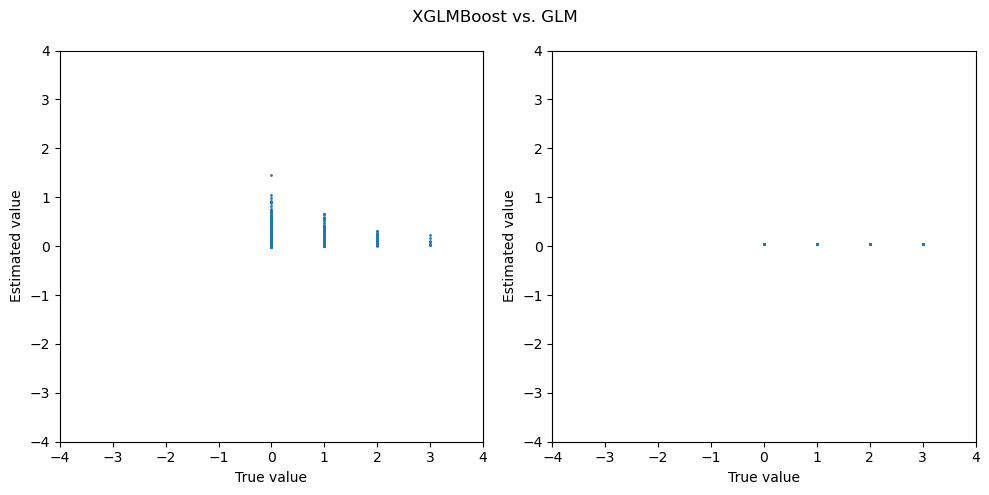

MSE XGLMBoost: 0.04137601892845959
MSE GLM: 0.04178410188957509


In [54]:
# Visualisierung der Vorhersagen
fig_performance = plt.figure(tight_layout=True, figsize=(10, 5))
spec = GridSpec(ncols=2, nrows=1, figure=fig_performance)
axs_perf = [
    fig_performance.add_subplot(spec[0, 0:1]),
    fig_performance.add_subplot(spec[0, 1:2]),
]

axs_perf[0].scatter(y_freq_test, y_pred_boosted_gb_test, s=1)
axs_perf[1].scatter(y_freq_test, y_pred_glm_test, s=1)

# Layout
for ax in axs_perf:
    ax.set_xlabel("True value")
    ax.set_ylabel("Estimated value")
    ax.set_xlim((-4, 4))
    ax.set_ylim((-4, 4))

fig_performance.suptitle("XGLMBoost vs. GLM")
plt.show()

print("MSE XGLMBoost: " + str(mean_squared_error(y_freq_test, y_pred_boosted_gb_test)))
print("MSE GLM: " + str(mean_squared_error(y_freq_test, y_pred_glm_test)))

Die Ergebnisse zeigen, dass der XGLMBoost-Ansatz zwar geringfügig besser abschneidet, aber noch weiter optimiert werden muss.